In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #official

dest_train='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_training/train_dataset/trainsamples_415-428.npy'
dest_val='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_validating/val_dataset/valsamples_413(4)-413(20).npy'
dest_test='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_testing/test_dataset/testsamples_413(0)-413(4).npy'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib
from PIL import Image
from torch import nn
import torch
from torchvision import transforms
import numpy as np
import os
from torchvision.utils import make_grid

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def rainbow2gray(image):
  mapvals=np.load('/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/mapvals_rainbow-gray.npy',allow_pickle=True)
  r = np.linspace(0,1, 256)
  newim = np.zeros((image.shape[0],image.shape[1]),dtype='uint8')
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          c = image[i,j,:3]
          c=c.astype('float32')/255.0
          gray=r[np.argmin(np.sum((mapvals - c)**2, axis=1))]
          newim[i,j] =  np.round(255.0*gray).astype('uint8')
  return newim

def gray2rainbow(gray):
  mapvals=np.load('/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/mapvals_rainbow-gray.npy',allow_pickle=True)
  rainbow=np.zeros((gray.shape[0],gray.shape[1],3),'float32')
  for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
      rainbow[i,j,:]=mapvals[gray[i,j]]
  return (255*rainbow).astype('uint8') 


def gray2rainbow_batch(ims): #(batch_size,1,64,64)
  rainbow=[]
  for i in range(ims.shape[0]):
    rainbow.append(gray2rainbow(ims[i][0]))
  return np.array(rainbow) 

In [4]:
class TopOpt(torch.utils.data.Dataset):
  def __init__(self,transform=None,type_='train',train_potion=0.8):
    self.transform=transform
    if type_=='train':
      self.dataset=np.load(dest_train,allow_pickle=True)
    if type_=='test':
      self.dataset=np.load(dest_test,allow_pickle=True)
    if type_=='val':
      self.dataset=np.load(dest_val,allow_pickle=True)

  def __len__(self):
    return len(self.dataset)
  def __getitem__(self,idx):
    img=Image.fromarray(self.dataset[idx][0])
    label=self.dataset[idx][1]
    if self.transform!=None:
      img=self.transform(img)
    return (label,img)

transform=transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()]) #,transforms.Normalize((0.5,),(0.5,))
dataset_train=TopOpt(transform=transform,type_='train')
dataset_test=TopOpt(transform=transform,type_='test')
dataset_val=TopOpt(transform=transform,type_='val')

dataloader_train=torch.utils.data.DataLoader(dataset_train,batch_size=len(dataset_train),shuffle=False,drop_last=True)
dataloader_test=torch.utils.data.DataLoader(dataset_test,batch_size=5,shuffle=False,drop_last=True)
dataloader_val=torch.utils.data.DataLoader(dataset_val,batch_size=15,shuffle=False,drop_last=True)

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.linear=nn.Linear(2,100)
    self.cnn=nn.Sequential(
        nn.ConvTranspose2d(100,64,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(64),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(32),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(16),
        nn.Dropout(0.2),
    
        nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(8),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(8,4,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(4),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(4,1,kernel_size=4,stride=2,padding=1),
    )

  def forward(self,x):
    x=x.float()
    x=x.view(-1,2)
    x=self.linear(x)
    x=x.view(-1,100,1,1)
    y=self.cnn(x)
    return y

cnn1=CNN()
save_path='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_training/model_1_CNN'
cnn1.load_state_dict(torch.load(save_path+'/weights.pth',map_location=torch.device('cpu')))
loss_train=np.load(save_path+'/loss_train.npy',allow_pickle=True)
loss_val=np.load(save_path+'/loss_val.npy',allow_pickle=True)

z_train,x_train=next(iter(dataloader_train))
z_val,x_val=next(iter(dataloader_val))
z_test,x_test=next(iter(dataloader_test))
with torch.no_grad():
  x_train=cnn1(z_train)
  x_val=cnn1(z_val)
  x_test=cnn1(z_test)

#Plot all the results

In [6]:
plot_dir='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/plots_images'
try:
  os.mkdir(plot_dir)
except:pass

In [5]:
def plot_color_grid(x_test,fig_name=None,plot_dir=None): #(batch_size,1, img_size,img_size) ->(5,1,64,64)
  a=gray2rainbow_batch((np.clip(255*x_test.cpu().detach().numpy(),0,255)).astype('uint8')).astype('float32')/255.0
  plt.figure(figsize=(100,100))     
  imgs=torch.Tensor(a).permute(0,3,1,2).data.cpu()
  grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
  plt.imshow(grid)
  plt.savefig(plot_dir+fig_name)
  plt.show()

def plot_gray_grid(x_test,fig_name=None,plot_dir=None):
  plt.figure(figsize=(100,100))     
  imgs=torch.Tensor(x_test).data.cpu()
  grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
  plt.imshow(grid)
  plt.savefig(plot_dir+fig_name)
  plt.show()

def plot_losses(loss_train=None,loss_val=None,figure_name=None,plot_dir=None):
  plt.figure()
  plt.plot(range(len(loss_val))[::10],list(loss_train)[::10],label='Train Loss',linewidth=3)
  plt.plot(range(len(loss_val))[::10],list(loss_val)[::10],label='Validation Loss',alpha=0.8,linewidth=2)
  plt.grid()
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

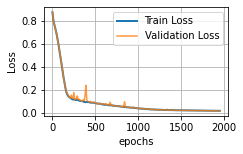

In [19]:
fig=plt.figure(figsize=(3.3,2.0))
plt.plot(range(len(loss_val))[::10],list(loss_train)[::10],label='Train Loss',linewidth=2)
plt.plot(range(len(loss_val))[::10],list(loss_val)[::10],label='Validation Loss',alpha=0.8,linewidth=1.5)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(plot_dir+'/cnn_learning_curve.jpg',bbox_inches="tight",dpi=5*fig.dpi)
plt.show()

In [20]:
from google.colab import files
files.download(plot_dir+'/cnn_learning_curve.jpg')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>